In [136]:
%matplotlib inline
import sys
import os
import getpass
import psycopg2
import psycopg2.extras
import numpy
import pandas
import matplotlib
from matplotlib import pyplot

In [159]:
# Connect to the database
if os.path.isfile( "/global/homes/r/raknop/secrets/decatdb_decat_decat_ro" ):
    with open( "/global/homes/r/raknop/secrets/decatdb_decat_decat_ro" ) as ifp:
        dbuser, dbpasswd = ifp.readline().strip().split()
else:
    dbuser = 'decat_ro'
    dbpasswd = getpass.getpass( 'decat readonly database password: ' )
db = psycopg2.connect(dbname='decat', user=dbuser, password=dbpasswd, host='decatdb.lbl.gov',
                      cursor_factory=psycopg2.extras.RealDictCursor)

In [160]:
# Figure out which rbid we're using
cursor = db.cursor()
cursor.execute( 'SELECT * FROM rbtypes' )
rbtypes = cursor.fetchall()
cursor.close()
for row in rbtypes:
    print( f"{row['id']} — {row['description']} (r/b cut {row['rbcut']})" )
rbid = int(input( "Select r/b type number: " ))
rbtype = None
for row in rbtypes:
    if row['id'] == rbid:
        rbtype = row
        break
if rbtype is None:
    raise ValueError( f'Unknown r/b type {rbid}' )

1 — Venkitesh Ayyar CNN paper model (r/b cut 0.6)
2 — jpeg majority 2021-11-05 (r/b cut 0.3)


Select r/b type number:  2


In [161]:
# Read scanscore into memory for further processing

q = ( 'SELECT s.id,s.object_id,s.username,s.goodbad,r.rb '
      'FROM scanscore s '
      'INNER JOIN objects o ON s.object_id=o.id '
      'INNER JOIN objectrbs r ON o.id=r.object_id '
      'WHERE r.rbtype_id=%(rbtype)s '
      'ORDER BY s.object_id' )
cursor = db.cursor()
cursor.execute(q, { "rbtype": rbtype["id"] } )
scanscore = pandas.DataFrame( cursor.fetchall() )
cursor.close()
db.close()

In [162]:
# Show how many objects each user has vetted
print( f'Note: only objects for which r/b type {rbtype["id"]} is saved in the database are counted' )
tots = scanscore.groupby(['username','goodbad'])['object_id'].count()
tots = tots.groupby(['username']).agg( num='sum',
                                       good_frac=lambda row: row.loc[:,'good'] / row.sum() )
tots = tots.sort_values("num", ascending=False)
print(tots)


Note: only objects for which r/b type 2 is saved in the database are counted
            num  good_frac
username                  
ruby      37354   0.118890
autumn    29015   0.183629
rknop     24843   0.191201
alexis    22813   0.106168
penugent   5105   0.119099
caitlin    3495   0.152217
tkennedy    608   0.238487


In [163]:
# Show stats on how many times a given object has been vetted
print( scanscore.groupby(['object_id'])['username'].count().reset_index(name='#vets')
       .groupby(['#vets'])['object_id'].count().reset_index(name="count") )

   #vets  count
0      1   9751
1      2  16623
2      3  16016
3      4   6716
4      5   1000
5      6     54


In [164]:
# Show counts of num goods and num bads.  Not terribly meaningful by itself, we
#   really need to do cross counts
print( scanscore.groupby( ['object_id', 'goodbad'] )['object_id'].count().reset_index(name='num')
       .groupby( ['goodbad', 'num'] )['num'].count().reset_index(name='count') )

   goodbad  num  count
0      bad    1  12129
1      bad    2  15752
2      bad    3  12719
3      bad    4   4918
4      bad    5    667
5      bad    6     35
6     good    1   6443
7     good    2   3205
8     good    3   1274
9     good    4    329
10    good    5     47


In [165]:
# Create a table where each row is one object, that has username and goodbad as lists
# This takes a few seconds
objtable = ( scanscore.groupby( ['object_id', 'rb'] )[ ["username", "goodbad"] ]
               .agg( tuple ) )
objtable["ngood"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "good" ).sum() )
objtable["nbad"] = objtable["goodbad"].apply( lambda x: ( numpy.array( x ) == "bad" ).sum() )
objtable.reset_index(inplace=True)

In [166]:
print(objtable)

       object_id        rb                  username          goodbad  ngood  \
0             63  0.069825     (ruby, rknop, alexis)  (bad, bad, bad)      0   
1            101  0.047672    (autumn, ruby, alexis)  (bad, bad, bad)      0   
2            162  0.080649     (ruby, alexis, rknop)  (bad, bad, bad)      0   
3            258  0.030767     (ruby, alexis, rknop)  (bad, bad, bad)      0   
4            324  0.025982                   (ruby,)           (bad,)      0   
...          ...       ...                       ...              ...    ...   
50155   10653339  0.038954                 (autumn,)           (bad,)      0   
50156   10653340  0.503102                 (autumn,)           (bad,)      0   
50157   10653537  0.011080  (ruby, autumn, penugent)  (bad, bad, bad)      0   
50158   10653554  0.008077            (ruby, alexis)       (bad, bad)      0   
50159   10653577  0.039683     (ruby, autumn, rknop)  (bad, bad, bad)      0   

       nbad  
0         3  
1         3

In [167]:
print( objtable.columns )

Index(['object_id', 'rb', 'username', 'goodbad', 'ngood', 'nbad'], dtype='object')


In [168]:
# Show consistency stats
maxgood = objtable['ngood'].max()
maxbad = objtable['nbad'].max()
print( f'{"nbad":>6s} |', end='' )
for j in range(maxbad+1):
    print( f' {j:5d} |', end='' )
print('\nngood  |', end='')
for j in range(maxbad+1):
    print( '       |', end='')
print('\n-------|', end='')
for j in range(maxbad+1):
    print( '-------|', end='')
print('')
for i in range(maxgood+1):
    print( f' {i:5d} |', end='' )
    for j in range(maxbad+1):
        n = ( ( objtable['ngood'] == i ) & ( objtable['nbad'] == j ) ).sum()
        print( f' {n:5} |', end='' )
    print('\n-------|', end='')
    for j in range(maxbad+1):
        print( '-------|', end='')
    print('')

  nbad |     0 |     1 |     2 |     3 |     4 |     5 |     6 |
ngood  |       |       |       |       |       |       |       |
-------|-------|-------|-------|-------|-------|-------|-------|
     0 |     0 |  8327 | 13139 | 11889 |  4812 |   660 |    35 |
-------|-------|-------|-------|-------|-------|-------|-------|
     1 |  1424 |  2145 |  2016 |   746 |   105 |     7 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     2 |  1339 |  1249 |   537 |    79 |     1 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     3 |   862 |   350 |    57 |     5 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     4 |   271 |    55 |     3 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|
     5 |    44 |     3 |     0 |     0 |     0 |     0 |     0 |
-------|-------|-------|-------|-------|-------|-------|-------|


In [169]:
# A function to add stats for a given user
def adduserstats( objtable, user ):
    if f"{user}_good" in objtable.columns:
        return
    sys.stderr.write( f"Adding isgood/isbad for {user}...\n" )
    def isgoodbad( row, user, goodbad ):
        dex = numpy.where(numpy.array( row["username"], ndmin=1 ) == user)[0]
        if dex.size == 0:
            return False
        else:
            return numpy.array( row["goodbad"], ndmin=1)[dex[0]] == goodbad
    objtable[f"{user}_good"] = objtable.apply( lambda row: isgoodbad(row, user, "good"), axis=1)
    objtable[f"{user}_bad"] = objtable.apply( lambda row: isgoodbad(row, user, "bad"), axis=1)
    sys.stderr.write( f"...done adding isgood/isbad for {user}.\n" )
    sys.stderr.flush()
    
# A function to print user stats
def userstats( objtable, user ):
    adduserstats( objtable, user )
    goodtable = objtable[ objtable[f"{user}_good"] ].groupby( [ f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated good:" )
    print( goodtable )
    badtable = objtable[ objtable[f"{user}_bad"] ].groupby( [f"ngood", f"nbad"] )["username"].count()
    print( f"Ratings for objects that {user} rated bad:" )
    print( badtable )
    
# A function to compare two users
def compareusers( objtable, user1, user2 ):
    adduserstats( objtable, user1 )
    adduserstats( objtable, user2 )
    goodgood = ( objtable[f"{user1}_good"] & objtable[f"{user2}_good"] ).sum()
    goodbad =  ( objtable[f"{user1}_good"] & objtable[f"{user2}_bad"] ).sum()
    badgood =  ( objtable[f"{user1}_bad"] & objtable[f"{user2}_good"] ).sum()
    badbad =   ( objtable[f"{user1}_bad"] & objtable[f"{user2}_bad"] ).sum()
    
    print( f'{user1:>8s} |   good   |    bad   |' )
    print( f'{user2:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )

# Compare user to majority
def uservsmajority( objtable, user, minrates=2, mindiff=2 ):
    adduserstats( objtable, user )
    goodtable = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+objtable["nbad"] >= minrates ) ]
    badtable = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
    goodgood = ( goodtable[f"{user}_good"] ).sum()
    goodbad = ( goodtable[f"{user}_bad"] ).sum()
    badgood = ( badtable[f"{user}_good"] ).sum()
    badbad = ( badtable[f"{user}_bad"] ).sum()
    
    print( f'{user} vs. majority (diff≥{mindiff}, n.rates≥{minrates})' )
    print( f' majority|   good   |    bad   |' )
    print( f'{user:<8s} |          |          |' )
    print( f'---------------------------------' )
    print( f'good     |   {goodgood:4d}   |   {badgood:4d}   |' )
    print( f'---------------------------------' )
    print( f'bad      |   {goodbad:4d}   |   {badbad:4d}   |' )
    print( f'---------------------------------' )


In [148]:
userstats( objtable, "ruby" )

Adding isgood/isbad for ruby...
...done adding isgood/isbad for ruby.


Ratings for objects that ruby rated good:
ngood  nbad
1      0        449
       1        531
       2        377
       3        118
       4         20
       5          2
2      0       1006
       1        560
       2        195
       3         19
3      0        782
       1        210
       2         22
       3          1
4      0        267
       1         38
       2          1
5      0         43
       1          2
Name: username, dtype: int64
Ratings for objects that ruby rated bad:
ngood  nbad
0      1        4082
       2       10718
       3       10947
       4        4680
       5         650
       6          35
1      1        1080
       2        1449
       3         601
       4          84
       5           5
2      1         573
       2         325
       3          59
       4           1
3      1         125
       2          35
       3           4
4      1          15
       2           2
5      1           1
Name: username, dtype: int64


In [149]:
compareusers( objtable, "rknop", "autumn" )

Adding isgood/isbad for rknop...
...done adding isgood/isbad for rknop.
Adding isgood/isbad for autumn...
...done adding isgood/isbad for autumn.


   rknop |   good   |    bad   |
autumn   |          |          |
---------------------------------
good     |   1772   |    880   |
---------------------------------
bad      |   1076   |   11477   |
---------------------------------


In [171]:
uservsmajority( objtable, "rknop", minrates=3, mindiff=2 )

rknop vs. majority (diff≥2, n.rates≥3)
 majority|   good   |    bad   |
rknop    |          |          |
---------------------------------
good     |   1275   |    336   |
---------------------------------
bad      |     37   |   14106   |
---------------------------------


In [172]:
def getgoodbadcounts( objtable, mode="unanimous", user=None, minrates=2, mindiff=2 ):
    if mode == "user":
        if user is None:
            raise ValueError( "Must specify user for mode user" )
        adduserstats( objtable, user )
        bads = objtable[ objtable[f"{user}_bad"] ]
        goods = objtable[ objtable[f"{user}_good"] ]
        title = f"{user} rankings"
    elif mode == "unanimous":
        bads = objtable[ ( objtable["ngood"] == 0 ) & ( objtable["nbad"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"] >= minrates ) & ( objtable["nbad"] == 0 ) ]
        title = f"Unanimous vetting with at least {minrates} rankings"
    elif mode =="majority":
        bads = objtable[ ( objtable["nbad"]-objtable["ngood"] >= mindiff ) &
                         ( objtable["nbad"]+objtable["ngood"] >= minrates ) ]
        goods = objtable[ ( objtable["ngood"]-objtable["nbad"] >= mindiff ) &
                          ( objtable["ngood"]+ objtable["nbad"] >= minrates ) ]
        title = f"Majority vetting w/ ≥{minrates} ratings and difference ≥ {mindiff}"
    else:
        raise ValueError( f"Unknown mode {mode}" )
    goodrb = goods["rb"].values
    badrb = bads["rb"].values
    return goodrb, badrb, title
    
# Make a histogram of rb scores
def plot_histrb( goodrb, badrb, title, rbcut=None, ylog=True, ylinmax=5000 ):
    # Have to do the range to 1.1 because numpy.hist doesn't count the right edge,
    #  and we definitely want to include rb=1.0
    bins = numpy.arange( 0., 1.2, 0.1 )
    # Hack so that things with 1.0 will be plotted in the top bin
    goodrb[ goodrb >= 1.0 ] = 0.999999
    badrb[ badrb >= 1.0 ] = 0.999999
    goodhist, junk = numpy.histogram( goodrb, bins )
    badhist, junk = numpy.histogram( badrb, bins )
    fig = pyplot.figure( figsize=(10,6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    if ylog:
        ax.set_yscale("log")
    else:
        ax.set_ylim(0, ylinmax)
    ax.set_title( title, fontsize=18 )
    ax.set_xlabel( 'rb', fontsize=18 )
    ax.set_ylabel( 'N', fontsize=18 )
    ax.tick_params( axis='both', labelsize=16 )
    ax.step( bins[:-1], goodhist, color='b', where="post" )
    ax.step( bins[:-1], badhist, color='r', where="post" )
    if rbcut is not None:
        ax.axvline( rbcut, linestyle="--", color="green" )
    fig.show()
    return fig

def plot_rbstats( goodrb, badrb, title, rbcut=None ):
    rb = numpy.arange(0, 1, 0.05)
    tpr = numpy.zeros_like( rb )
    fpr = numpy.zeros_like( rb )
    mdr = numpy.zeros_like( rb )
    fracpassgood = numpy.zeros_like( rb )
    for i, rbval in enumerate( rb ):
        fp = ( badrb >= rbval ).sum()
        tp = ( goodrb >= rbval ).sum()
        fn = ( goodrb < rbval ).sum()
        tn = ( badrb < rbval ).sum()
        # tpr = fraction good things that got classified as good
        tpr[i] = tp / ( tp + fn )
        # fpr = fraction bad things that got classified as good
        fpr[i] = fp / ( fp + tn )
        # mdr = fraction of good things that got classified as bad
        mdr[i] = fn / ( tp + fn )
        # fracpassgood = fraction of things classified as good that are really good
        fracpassgood[i] = tp / ( tp + fp )
        
    if rbcut is None:
        rbcut = rbtype['rbcut']
    fp = ( badrb >= rbcut ).sum()
    tp = ( goodrb >= rbcut ).sum()
    fn = ( goodrb < rbcut ).sum()
    tn = ( badrb < rbcut ).sum()
    tprcut = tp / ( tp + fn )
    fprcut = fp / ( fp + tn )
    mdrcut = fn / ( tp + fn )
    fracpassgoodcut = tp / ( tp + fp )
        
    fig = pyplot.figure( figsize=(12, 4), tight_layout=True )
    zerodist = numpy.sqrt( fpr**2 + mdr**2 )
    wmin = numpy.where( zerodist == zerodist.min() )[0]
    fprmax = min( 3 * fpr[wmin], 1. )
    mdrmax = min( 3 * mdr[wmin], 1. )
    ax = fig.add_subplot( 1, 3, 1 )
    ax.set_xlabel( 'Missed Detection Rate (MDR)' )
    ax.set_ylabel( 'False Positive Rate (FPR)' )
    ax.set_xlim( 0, mdrmax )
    ax.set_ylim( 0, fprmax )
    ax.xaxis.set_minor_locator( matplotlib.ticker.AutoMinorLocator() )
    ax.yaxis.set_minor_locator( matplotlib.ticker.AutoMinorLocator() )
    ax.grid( which='major', color='#999999' )
    ax.grid( which='minor', color='#cccccc' )
    ax.plot( mdr, fpr, color='blue' )
    ax.plot( mdrcut, fprcut, linestyle="", color='red', marker='o', markersize=6 ) 
    
    ax = fig.add_subplot( 1, 3, 2 )
    ax.set_xlabel( 'rb ≥ this to pass' )
    ax.set_ylabel( 'FPR/MDR' )
    ax.plot( rb, fpr, color='red', label="FPR" )
    ax.plot( rb, mdr, color='orange', label="MDR" )
    ax.axvline( rbcut, linestyle="--", color="green" )
    ax.legend()
    
    ax = fig.add_subplot( 1, 3, 3 )
    ax.set_xlabel( 'Missed Detection Rate (MDR)' )
    ax.set_ylabel( 'Stream Cleanliness (tp/(tp+fp))' )
    ax.xaxis.set_minor_locator( matplotlib.ticker.AutoMinorLocator() )
    ax.yaxis.set_minor_locator( matplotlib.ticker.AutoMinorLocator() )
    ax.grid( which='major', color='#999999' )
    ax.grid( which='minor', color='#cccccc' )
    # ax.set_xlim( 0, 0.6 )
    # ax.set_ylim( 0.4, 1 )
    ax.plot( mdr, fracpassgood, color='blue' )
    subset = numpy.arange( 2, len(rb), 2 )
    ax.plot( mdr[subset], fracpassgood[subset], linestyle="", marker='o', markersize=3, color='blue' )
    for i in subset:
        ax.annotate( f'{rb[i]:.2f}', ( mdr[i], fracpassgood[i] ),
                     xytext=(4, -5), textcoords='offset points',
                     fontsize=10 )
    ax.plot( mdrcut, fracpassgoodcut, color='red', linestyle="", marker='o', markersize=6 )
    fig.show()
    return fig
 
def histrb( objtable, rbcut=None, ylog=True, ylinmax=5000, *args, **kwargs ):
    goodrb, badrb, title = getgoodbadcounts( objtable, *args, **kwargs )
    return plot_histrb( goodrb, badrb, title, rbcut=rbcut, ylog=ylog, ylinmax=ylinmax )

def rbstats( objtable, rbcut=None, *args, **kwargs ):
    goodrb, badrb, title = getgoodbadcounts( objtable, *args, **kwargs )
    return plot_rbstats( goodrb, badrb, title, rbcut=rbcut )

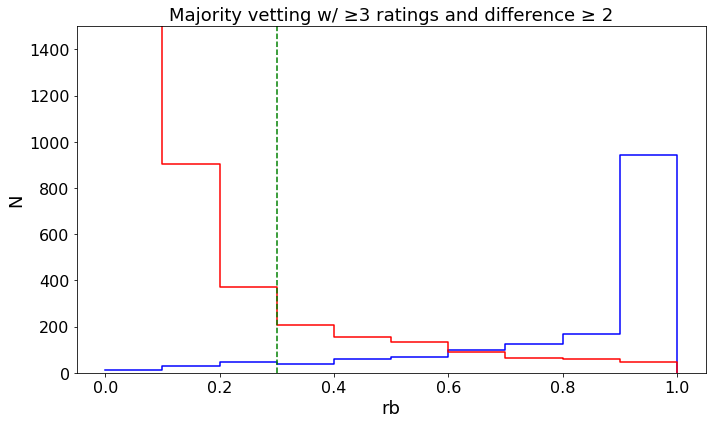

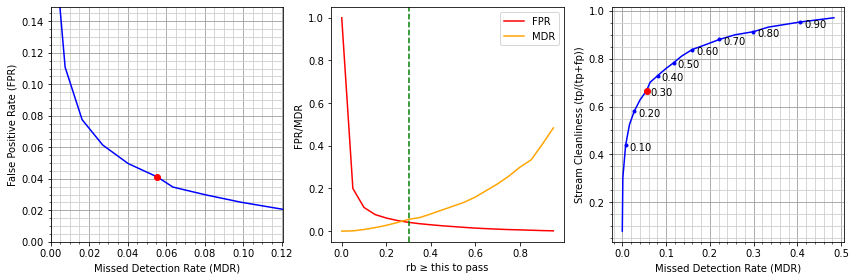

In [174]:
mode = "majority"    # unanimous, majority, or user
minrates = 3          # Minimum number of ratings to be included in majority or unanimous
mindiff = 2           # Minimum difference (ngood-bad or nbad-ngood) to be included in majority
user = "rknop"        # user for user
fig = histrb( objtable, mode=mode, user=user, minrates=minrates, mindiff=mindiff, 
              ylog=False, ylinmax=1500, rbcut=rbtype['rbcut'] )
fig.savefig( "vettingvsrb.svg" )
fig2 = rbstats( objtable, mode=mode, user=user, minrates=minrates, mindiff=mindiff, rbcut=None )